In [1]:
import pandas as pd

In [2]:
def clean_UNdata(df):
        to_drop = ['Region/Country/Area','Footnotes','Source']
        df.drop(to_drop, axis=1, inplace = True)
        df.rename(columns = {'Unnamed: 1':'Country'}, inplace = True)
        return df

def filter_area(df, area):
    """ Filters data rows by type of area"""
    dff = df.copy()
    
    c = dff[dff['Country']=='Afghanistan'].index[0]
    a = dff[dff['Country']=='Africa'].index[0]
    
    if area != 'countries':
        dff.drop(df.index[c:], inplace = True)
    if area != 'areas':
        dff.drop(df.index[a:c], inplace = True)
    if area != 'totals':
        dff.drop(df.index[:a], inplace = True)
    if area == 'all':
        dff = df
    return dff

def filter_year(df, year):
    """Filters rows by year"""
    if year != None:
        df = df[df['Year'] == year]
        df.drop(['Year'], axis = 1, inplace = True)
        df.columns = [str(year) + ' ' + column for column in df.columns]
    return df

In [3]:
def get_cpi(series = 'Both', year = None):
    """ Returns a dataframe object containing Consumer Pricing Index by country. The series argument can be 
    passed a string ('Both', 'General', or 'Food') and will give the corresponding CPI's, and the year argument can be passed
    an integer which will filter by a specific year (1995, 2005, 2010, 2015, 2016, 2017, 2018) of data
    """
    
    cpi = pd.read_csv('SYB62_128_201907_Consumer Price Index.csv', skiprows = 1, encoding='latin-1')
    
    #Import and clean
    
    cpi = clean_UNdata(cpi)
    cpi.rename(columns = {'Value':'CPI Value'}, inplace = True)
    cpi.Series = cpi.Series.str.split().str[-1].str.strip()
    
    
    #Remove data of unused series types and change column names appropriately
    if (series != None) and (series != 'Both'):
        cpi = cpi[cpi['Series'] == series]
        cpi.drop(['Series'], axis = 1, inplace = True)
        cpi.rename(columns = {'CPI Value':'CPI {} Value'.format(series)}, inplace = True)
    
    #Merge both series types into named columns if 'Both'
    if series == 'Both':
        cpi = pd.merge(cpi[cpi['Series'] == 'General'],
                       cpi[cpi['Series'] == 'Food'],
                      how = 'outer', on = ['Country', 'Year'])
        cpi.rename(columns = {'CPI Value_x':'CPI General Value', 'CPI Value_y':'CPI Food Value'},inplace=True)
        cpi.drop(['Series_x', 'Series_y'], axis = 1, inplace=True)
    
    #Set Country as index
    cpi.set_index('Country', inplace = True)
    
    #Filter by year and change column names appropriately
    cpi = filter_year(cpi, year)
    
    cpi.replace(',','',regex = True,inplace = True)
    cpi = cpi.apply(pd.to_numeric)
    
    return cpi

get_cpi(series = 'Both', year = 2017).head(10)

,2017 CPI General Value,2017 CPI Food Value
Country,,
Afghanistan,144.7692,113.9270
Åland Islands,111.1000,113.7000
Albania,115.0798,127.3438
Algeria,142.3842,142.5363
Andorra,105.4889,112.2576
Angola,280.7633,286.6098
Anguilla,105.8576,112.3082
Antigua and Barbuda,112.4502,NaN
Argentina,112.8871,111.6830


In [4]:
def get_gdp(area = 'countries', year = None):
    """ Returns a dataframe object containing GDP information by country. The area argument can be 
    passed a string ('all', 'totals', 'areas', or 'countries') and will give the corresponding area data, 
    and the year argument can be passed an integer which will filter by a specific year (1985, 1995, 2005, 2010, 
    2015, 2016, 2017) of data
    """

    #Import and Clean
    gdp = pd.read_csv('SYB62_230_201904_GDP and GDP Per Capita.csv', skiprows = 1, encoding='latin-1')
    
    gdp = clean_UNdata(gdp)
    gdp.rename(columns = {'Value':'GDP Value (USD)'}, inplace = True)
    
    gdp = filter_area(gdp,area)
            
    #Builds table with different GDP measures
    def build_gdp_table(gdp):
        """ A function building separate Series values into columns of a table. This function can be replaced by a pivot table"""
        build_gdp = pd.merge(gdp[gdp['Series'] == 'GDP in current prices (millions of US dollars)'],
                gdp[gdp['Series'] == 'GDP per capita (US dollars)'],
                how = 'outer', on = ['Country', 'Year'])
        build_gdp.rename(columns = {'GDP Value (USD)_x':'GDP in current prices (millions of US dollars)', 
                                    'GDP Value (USD)_y':'GDP per capita (US dollars)'}, inplace = True)
        build_gdp = pd.merge(build_gdp,
                gdp[gdp['Series'] == 'GDP in constant 2010 prices (millions of US dollars)'],
                how = 'outer', on = ['Country', 'Year'])
        build_gdp = pd.merge(build_gdp,
                gdp[gdp['Series'] == 'GDP real rates of growth (percent)'],
                how = 'outer', on = ['Country', 'Year'])
        build_gdp.rename(columns = {'GDP Value (USD)_x':'GDP in constant 2010 prices (millions of US dollars)',
                                    'GDP Value (USD)_y':'GDP real rates of growth (percent)'}, inplace = True)
        build_gdp.drop(['Series_x', 'Series_y'], axis = 1, inplace = True)
        return build_gdp
    gdp = build_gdp_table(gdp)
    
    gdp.set_index('Country', inplace = True)
    
    gdp = filter_year(gdp, year)
    
    gdp.replace(',','',regex = True,inplace = True)
    gdp = gdp.apply(pd.to_numeric)
    
    return gdp

get_gdp(area = 'areas', year = 2017).head()

,2017 GDP in current prices (millions of US dollars),2017 GDP per capita (US dollars),2017 GDP in constant 2010 prices (millions of US dollars),2017 GDP real rates of growth (percent)
Country,,,,
Africa,2215906,1766,2397256,2.9
Northern Africa,657861,2823,714839,4.1
Sub-Saharan Africa,1558044,1525,1682416,2.4
Eastern Africa,350941,834,313742,5.6
Middle Africa,250577,1533,230035,-0.5


In [5]:
def get_pop(area = 'countries', year = None):
    
    pop = pd.read_csv('SYB62_1_201907_Population, Surface Area and Density.csv', skiprows=1, encoding = 'latin-1')
    pop = clean_UNdata(pop)

    pop = filter_area(pop, area)

    pop = pd.pivot_table(pop, index=['Country', 'Year'], columns='Series')
    pop.columns = pop.columns.droplevel()

    pop.reset_index(level = 1, inplace = True)

    pop = filter_year(pop, year)

    return pop

get_pop(year = 2017).head()

,2017 Population aged 0 to 14 years old (percentage),2017 Population aged 60+ years old (percentage),2017 Population density,2017 Population mid-year estimates (millions),2017 Population mid-year estimates for females (millions),2017 Population mid-year estimates for males (millions),2017 Sex ratio (males per 100 females),2017 Surface area (thousand km2)
Country,,,,,,,,
Afghanistan,43.6825,4.0661,55.5956,36.2961,17.6441,18.6520,105.7122,652.864
Albania,18.0283,19.0889,105.2616,2.8842,1.4146,1.4696,103.8886,28.748
Algeria,29.6396,9.3050,17.3777,41.3892,20.4824,20.9068,102.0717,2381.741
American Samoa,NaN,NaN,278.2050,0.0556,NaN,NaN,NaN,0.199
Andorra,NaN,NaN,163.7553,0.0770,NaN,NaN,NaN,0.468


In [28]:
def get_trade(area = 'countries', year = None):
    
    trade = pd.read_csv('SYB62_123_201907_Total Imports, Exports and Balance of Trade.csv',skiprows=1)
    trade = clean_UNdata(trade)

    trade = filter_area(trade, area)
    trade.drop(['System of trade footnote'],axis=1, inplace=True)

    trade = pd.pivot_table(trade, index=['Country', 'Year'], columns='Series')
    trade.columns = trade.columns.droplevel()

    trade.reset_index(level = 1, inplace = True)

    trade = filter_year(trade, year)
    
    return trade

get_trade(year=2017).head()

,2017 Balance imports/exports (millions of US dollars),2017 Exports FOB (millions of US dollars),2017 Imports CIF (millions of US dollars)
Country,,,
Afghanistan,-6684.1468,700.0461,7384.1929
Albania,-2992.5610,2301.3410,5293.9019
Algeria,-10861.8986,35191.1174,46053.0160
Andorra,-1360.1367,120.0902,1480.2269
Angola,18724.7517,32265.2265,13540.4748


In [7]:
# Data Analysis

In [59]:
year = 2017
df = pd.merge(get_pop(year=year),get_gdp(year=year), how = 'outer', left_index = True, right_index = True)
df = pd.merge(df, get_cpi(year = year), how = 'outer', left_index = True, right_index = True)
df = pd.merge(df, get_trade(year=year), how = 'outer', left_index = True, right_index = True)

df[df['2017 CPI General Value'] > 200]
df.drop(['South Sudan','Solomon Islands'],inplace = True)

#df[df['2017 GDP in current prices (millions of US dollars)'] > 10000000]

df['2017 Exports vs. Imports per GDP (millions of US dollars)'] = (df['2017 Balance imports/exports (millions of US dollars)']
                                                                          /df['2017 GDP in current prices (millions of US dollars)'])

df

,2017 Population aged 0 to 14 years old (percentage),2017 Population aged 60+ years old (percentage),2017 Population density,2017 Population mid-year estimates (millions),2017 Population mid-year estimates for females (millions),2017 Population mid-year estimates for males (millions),2017 Sex ratio (males per 100 females),2017 Surface area (thousand km2),2017 GDP in current prices (millions of US dollars),2017 GDP per capita (US dollars),2017 GDP in constant 2010 prices (millions of US dollars),2017 GDP real rates of growth (percent),2017 CPI General Value,2017 CPI Food Value,2017 Balance imports/exports (millions of US dollars),2017 Exports FOB (millions of US dollars),2017 Imports CIF (millions of US dollars),2017 Exports vs. Imports per GDP (millions of US dollars)
Country,,,,,,,,,,,,,,,,,,
Afghanistan,43.6825,4.0661,55.5956,36.2961,17.6441,18.6520,105.7122,652.8640,21993.0,619.0,22175.0,2.5,144.7692,113.9270,-6684.1468,7.000461e+02,7.384193e+03,-0.303922
Albania,18.0283,19.0889,105.2616,2.8842,1.4146,1.4696,103.8886,28.7480,13039.0,4450.0,13988.0,3.8,115.0798,127.3438,-2992.5610,2.301341e+03,5.293902e+03,-0.229508
Algeria,29.6396,9.3050,17.3777,41.3892,20.4824,20.9068,102.0717,2381.7410,167555.0,4055.0,198613.0,1.4,142.3842,142.5363,-10861.8986,3.519112e+04,4.605302e+04,-0.064826
American Samoa,NaN,NaN,278.2050,0.0556,NaN,NaN,NaN,0.1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Andorra,NaN,NaN,163.7553,0.0770,NaN,NaN,NaN,0.4680,3013.0,39153.0,3377.0,1.7,105.4889,112.2576,-1360.1367,1.200902e+02,1.480227e+03,-0.451423
Angola,46.9530,3.5797,23.9166,29.8168,15.0675,14.7493,97.8886,1246.7000,126506.0,4247.0,99277.0,-2.5,280.7633,286.6098,18724.7517,3.226523e+04,1.354047e+04,0.148015
Anguilla,NaN,NaN,165.6556,0.0149,NaN,NaN,NaN,0.0910,281.0,18861.0,256.0,-7.7,105.8576,112.3082,-176.2371,4.492600e+00,1.807296e+02,-0.627178
Antigua and Barbuda,22.2319,12.7712,216.8773,0.0954,0.0494,0.0460,93.0156,0.4420,1510.0,14803.0,1382.0,3.0,112.4502,NaN,-567.4286,6.239060e+01,6.298192e+02,-0.375781
Argentina,24.9268,15.1301,16.0548,43.9371,22.5173,21.4198,95.1258,2780.4000,637486.0,14400.0,463442.0,2.9,112.8871,111.6830,-8515.1046,5.838419e+04,6.689930e+04,-0.013357


In [9]:
df[df['2017 CPI Food Value'] > 200][['2017 CPI Food Value', '2017 CPI General Value']]

,2017 CPI Food Value,2017 CPI General Value
Country,,
Angola,286.6098,280.7633
Bangladesh,257.9225,161.1360
Barbados,230.9250,177.6083
Cambodia,206.7308,124.5715
Egypt,313.8917,231.1053
Ethiopia,267.0872,249.2544
Guinea,256.3727,218.7104
Kenya,214.8249,172.4282
Malawi,262.4167,340.2421


In [90]:
#df.corr()

df[['2017 Population mid-year estimates (millions)', '2017 Population density', '2017 Surface area (thousand km2)', '2017 GDP per capita (US dollars)','2017 CPI Food Value','2017 Balance imports/exports (millions of US dollars)']].corr()

,2017 Population mid-year estimates (millions),2017 Population density,2017 Surface area (thousand km2),2017 GDP per capita (US dollars),2017 CPI Food Value,2017 Balance imports/exports (millions of US dollars)
2017 Population mid-year estimates (millions),1.000000,-0.025152,0.456141,-0.064414,0.023867,0.074510
2017 Population density,-0.025152,1.000000,-0.058257,0.475483,0.002878,0.000455
2017 Surface area (thousand km2),0.456141,-0.058257,1.000000,0.027295,0.050087,-0.060963
2017 GDP per capita (US dollars),-0.064414,0.475483,0.027295,1.000000,-0.340838,-0.074762
2017 CPI Food Value,0.023867,0.002878,0.050087,-0.340838,1.000000,-0.002008
2017 Balance imports/exports (millions of US dollars),0.074510,0.000455,-0.060963,-0.074762,-0.002008,1.000000


In [11]:
df.corrwith(df['2017 CPI General Value'])

2017 Population aged 0 to 14 years old (percentage)                 0.309978
2017 Population aged 60+ years old (percentage)                    -0.253287
2017 Population density                                            -0.021605
2017 Population mid-year estimates (millions)                       0.040375
2017 Population mid-year estimates for females (millions)           0.033532
2017 Population mid-year estimates for males (millions)             0.030897
2017 Sex ratio (males per 100 females)                             -0.099411
2017 Surface area (thousand km2)                                    0.041382
2017 GDP in current prices (millions of US dollars)                -0.090913
2017 GDP per capita (US dollars)                                   -0.308514
2017 GDP in constant 2010 prices (millions of US dollars)          -0.092903
2017 GDP real rates of growth (percent)                             0.082937
2017 CPI General Value                                              1.000000

In [12]:
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


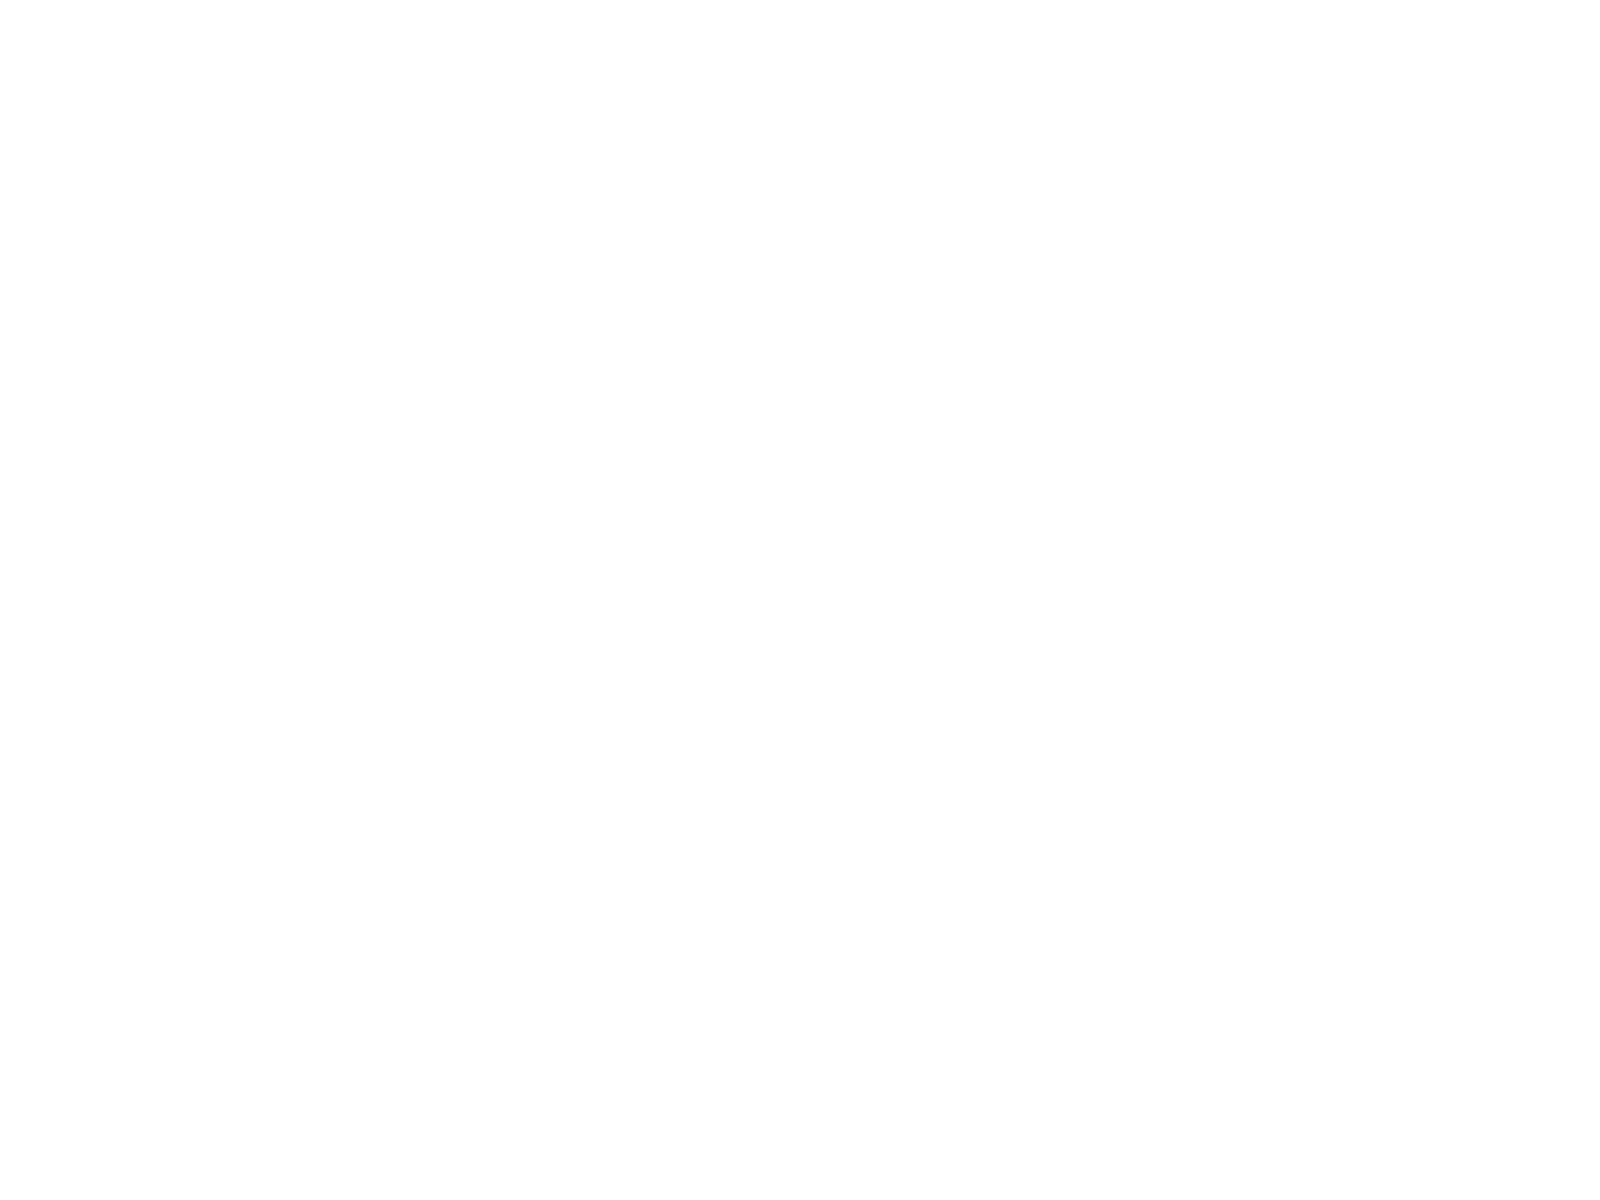

In [13]:
pd.tools.plotting.scatter_matrix(df[['2017 Population mid-year estimates (millions)', '2017 Population density', '2017 GDP per capita (US dollars)','2017 CPI Food Value','2017 Balance imports/exports (millions of US dollars)']]);


<IPython.core.display.Javascript object>


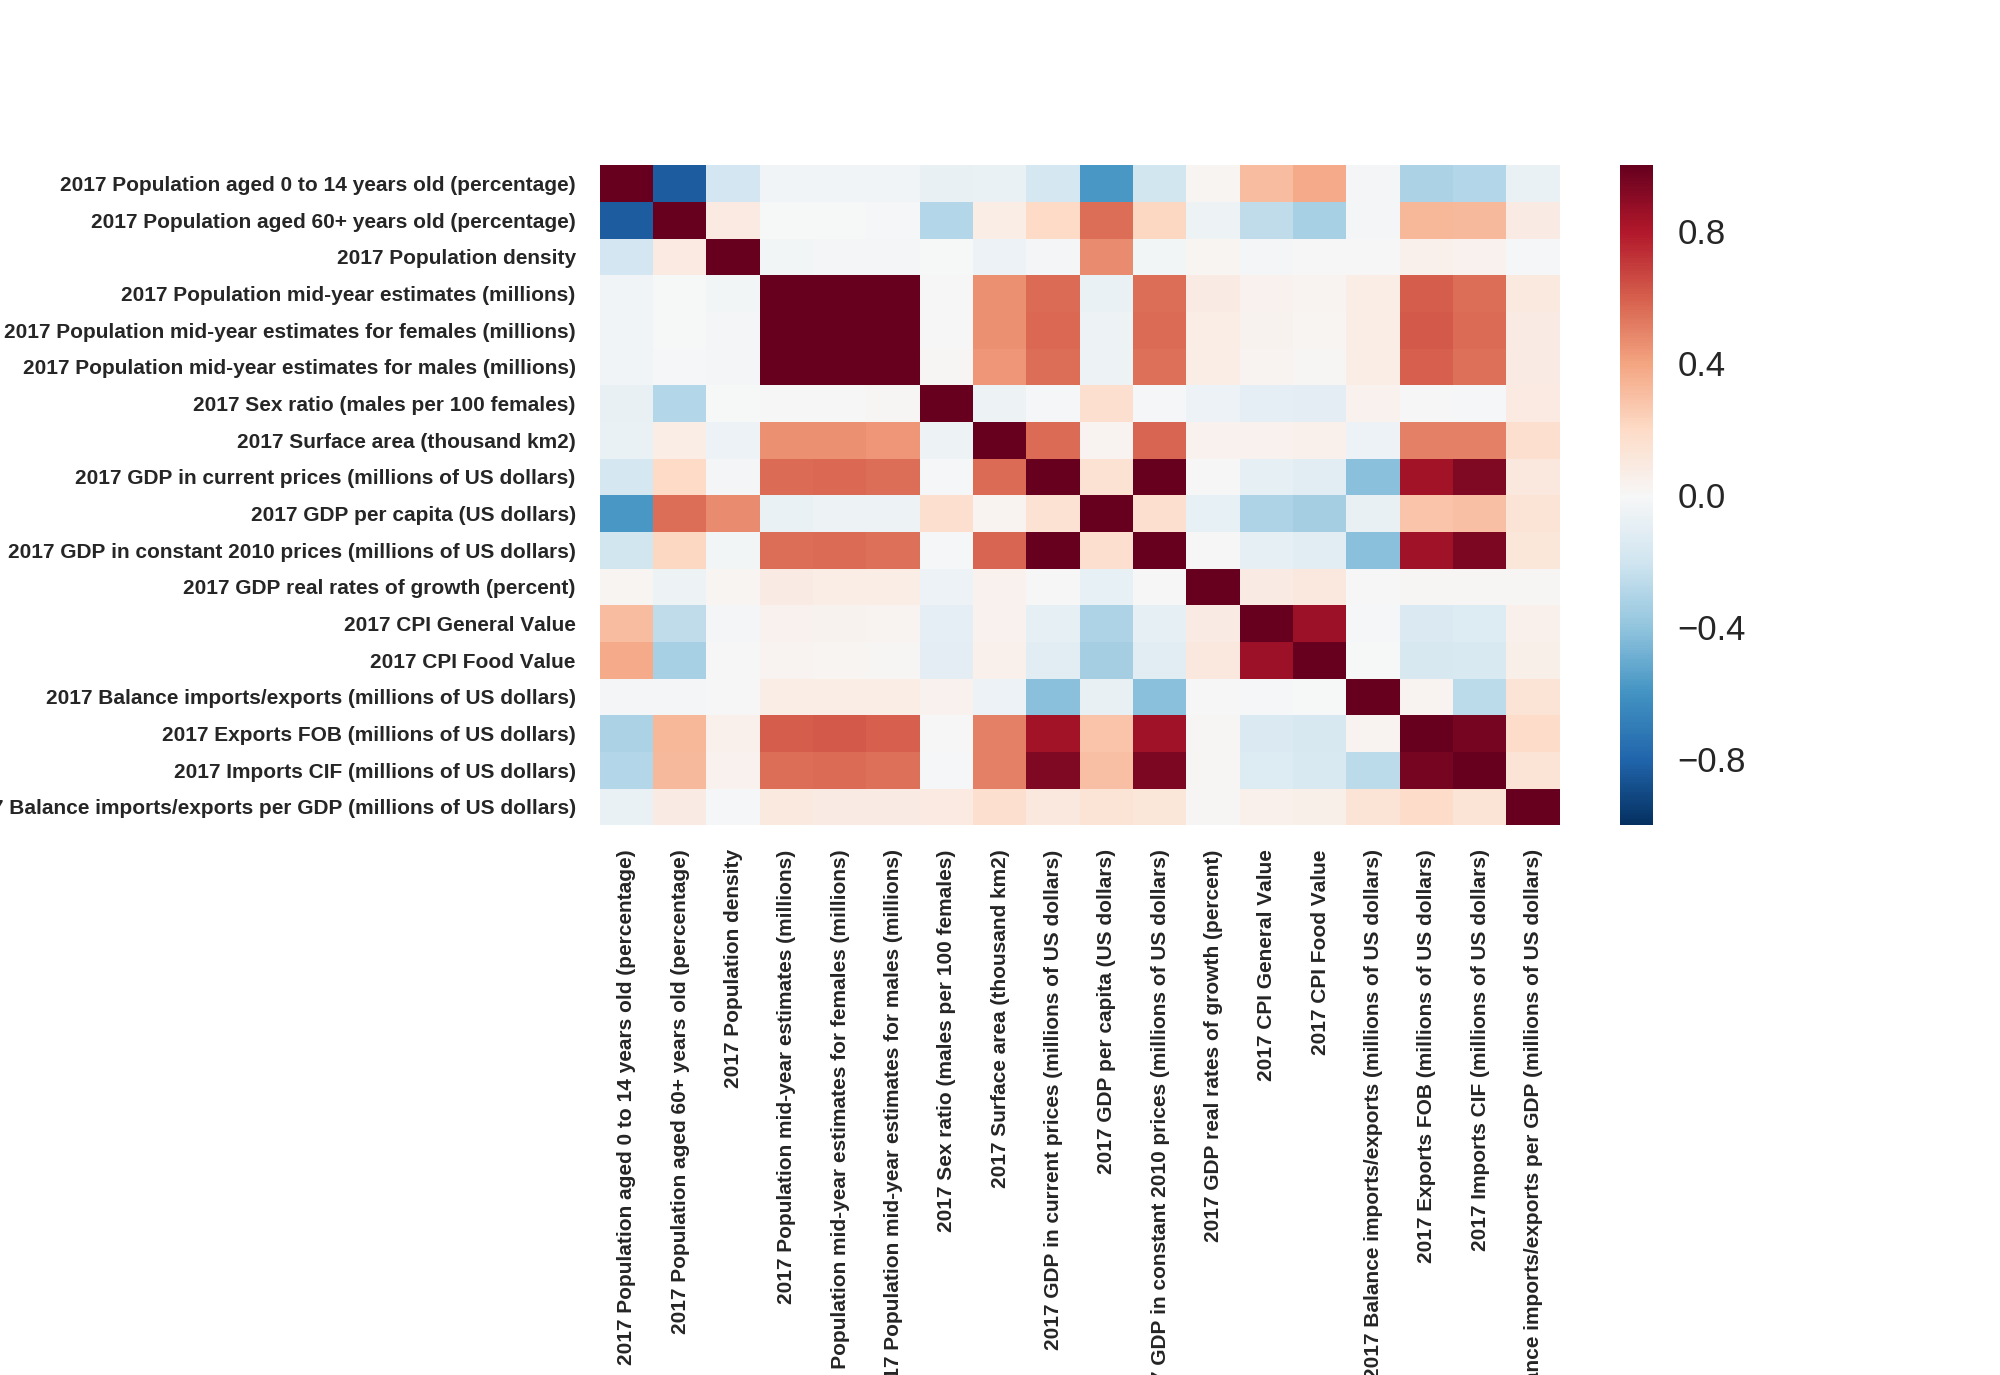

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()
sns.heatmap(df.corr(), xticklabels=True, yticklabels=True, robust=True)
plt.yticks(rotation=0, fontsize=6, fontweight='bold')
plt.xticks(rotation=90, fontsize=6, fontweight='bold') 
plt.subplots_adjust(left=0.3, bottom=0.4)

In [15]:
%matplotlib notebook

<IPython.core.display.Javascript object>


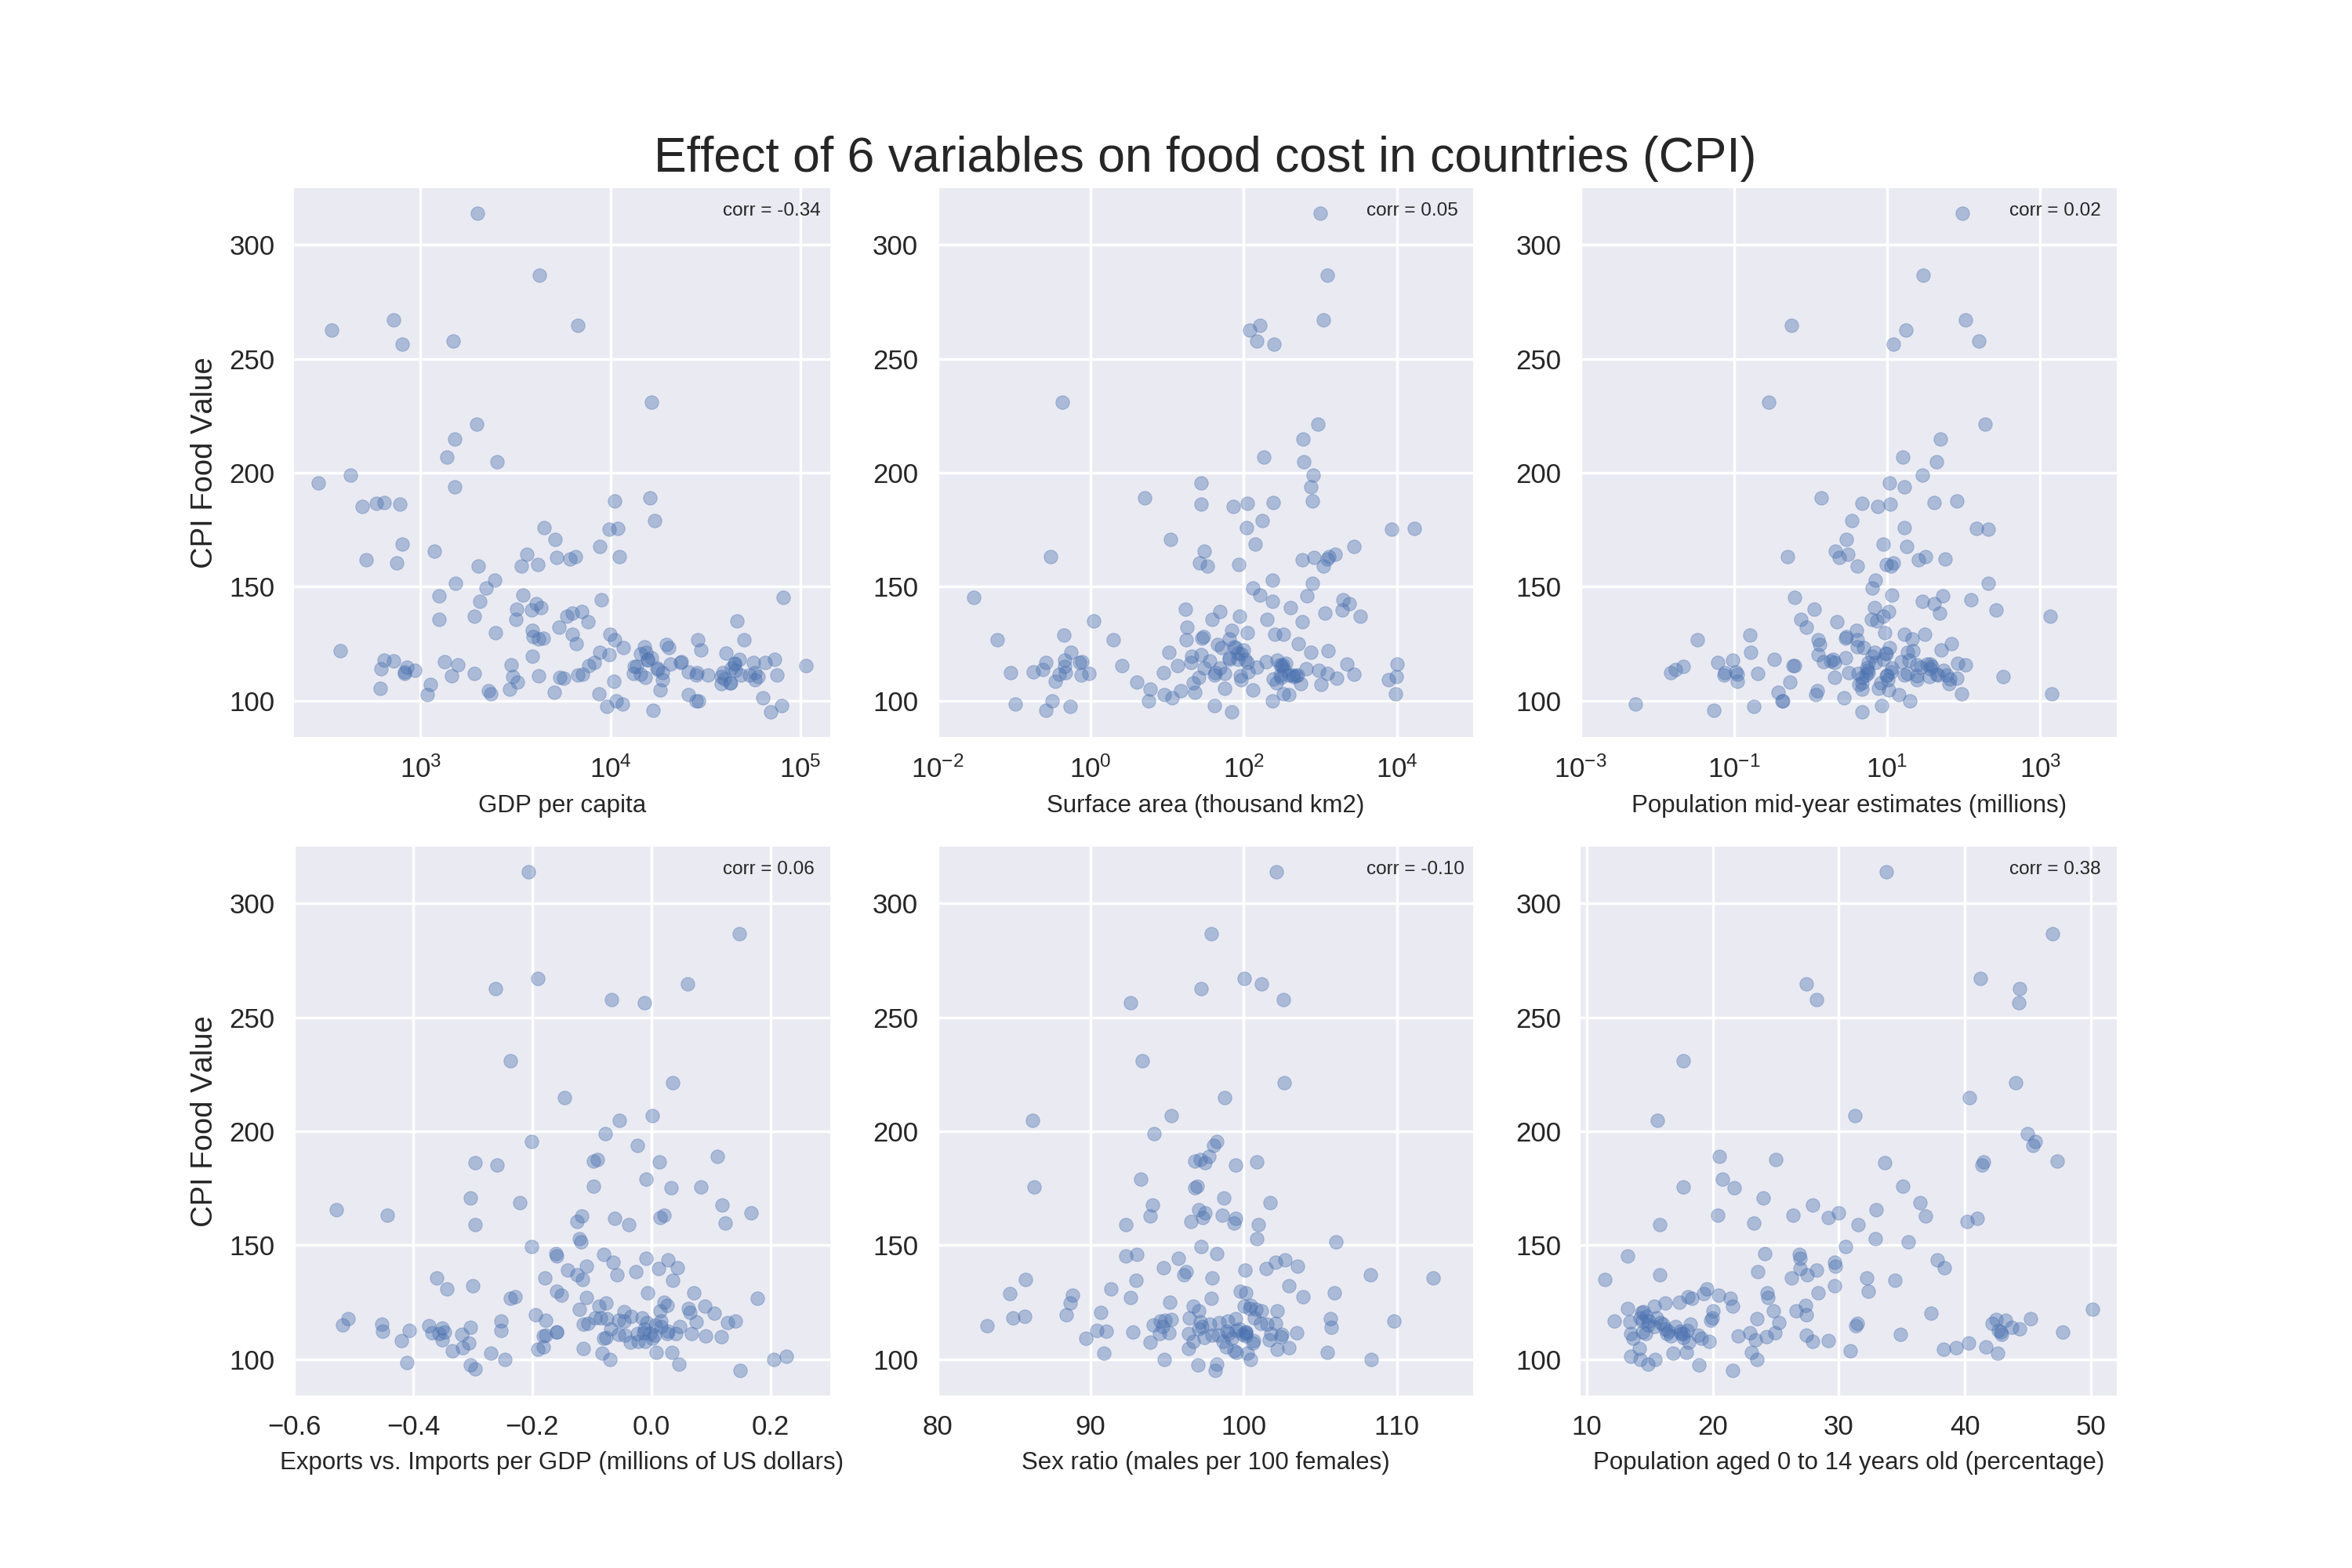

In [121]:
plt.figure(figsize=(12,8))

plt.subplot(2, 3, 1)
plt.scatter(df['2017 GDP per capita (US dollars)'], df['2017 CPI Food Value'], s=25, alpha=0.4)
plt.xlabel('GDP per capita', fontsize=9)
plt.ylabel('CPI Food Value')
plt.xscale('log')
plt.annotate('corr = {:.2f}'.format(df['2017 GDP per capita (US dollars)'].corr(df['2017 CPI Food Value'])), 
             xy=(0.80, 0.95), xycoords='axes fraction', fontsize = 7)

plt.subplot(2, 3, 2)
plt.scatter(df['2017 Surface area (thousand km2)'], df['2017 CPI Food Value'], s=25, alpha=0.4)
plt.xlabel('Surface area (thousand km2)', fontsize=9)
plt.xscale('log')
plt.xlim(0.01,100000)
plt.annotate('corr = {:.2f}'.format(df['2017 Surface area (thousand km2)'].corr(df['2017 CPI Food Value'])), 
             xy=(0.80, 0.95), xycoords='axes fraction', fontsize = 7)

plt.title('Effect of 6 variables on food cost in countries (CPI)',fontsize=18)

plt.subplot(2, 3, 3)
plt.scatter(df['2017 Population mid-year estimates (millions)'], df['2017 CPI Food Value'], s=25, alpha=0.4)
plt.xlabel('Population mid-year estimates (millions)', fontsize=9)
plt.xscale('log')
plt.xlim(0.001,10000)
plt.annotate('corr = {:.2f}'.format(df['2017 Population mid-year estimates (millions)'].corr(df['2017 CPI Food Value'])), 
             xy=(0.80, 0.95), xycoords='axes fraction', fontsize = 7)

plt.subplot(2, 3, 4)
plt.scatter(df['2017 Exports vs. Imports per GDP (millions of US dollars)'], df['2017 CPI Food Value'], s=25, alpha=0.4)
plt.xlabel('Exports vs. Imports per GDP (millions of US dollars)', fontsize=9)
plt.xlim(-0.6,0.3)
plt.ylabel('CPI Food Value')
plt.annotate('corr = {:.2f}'.format(df['2017 Exports vs. Imports per GDP (millions of US dollars)'].corr(df['2017 CPI Food Value'])), 
             xy=(0.80, 0.95), xycoords='axes fraction', fontsize = 7)

plt.subplot(2, 3, 5)
plt.scatter(df['2017 Sex ratio (males per 100 females)'], df['2017 CPI Food Value'], s=25, alpha=0.4)
plt.xlabel('Sex ratio (males per 100 females)', fontsize=9)
plt.xlim(80,115)
#plt.xscale('log')
plt.annotate('corr = {:.2f}'.format(df['2017 Sex ratio (males per 100 females)'].corr(df['2017 CPI Food Value'])), 
             xy=(0.80, 0.95), xycoords='axes fraction', fontsize = 7)

plt.subplot(2, 3, 6)
plt.scatter(df['2017 Population aged 0 to 14 years old (percentage)'], df['2017 CPI Food Value'], s=25, alpha=0.4)
plt.xlabel('Population aged 0 to 14 years old (percentage)', fontsize=9)
plt.annotate('corr = {:.2f}'.format(df['2017 Population aged 0 to 14 years old (percentage)'].corr(df['2017 CPI Food Value'])), 
             xy=(0.80, 0.95), xycoords='axes fraction', fontsize = 7)

plt.savefig('foodcpivars.png')